In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.tensorflow.data import _parse_function

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/te

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

In [5]:
print(tf.__version__, tfp.__version__, tf.__file__)

2.0.0-beta1 0.7.0-dev20190510 /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/__init__.py


In [6]:
TRAIN_SIZE=482608
BATCH_SIZE=64
TEST_SIZE=10000
DIMS = (128, 128, 1)
N_TRAIN_BATCHES =int((TRAIN_SIZE-TEST_SIZE)/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_SIZE/BATCH_SIZE)
TRAIN_BUF = 1000
TEST_BUF = 1000

In [7]:
network_type = 'GAIA'

In [8]:
DATASET_ID = 'european_starling_gentner_segmented'

In [9]:
record_loc = DATA_DIR / 'tfrecords' / "starling.tfrecords"

In [10]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [11]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "indv": tf.string,
}

In [12]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: _parse_function(x, data_types=data_types))

In [13]:
spec, index, indv  = next(iter(dataset))

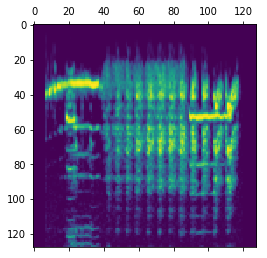

In [14]:
plt.matshow(spec.numpy().reshape(DIMS).squeeze())

In [15]:
test_dataset = dataset.take(TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)
train_dataset = dataset.skip(TEST_SIZE).take(TRAIN_SIZE-TEST_SIZE).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [16]:
N_Z = 128

def unet_convblock_down(
    _input,
    channels=16,
    kernel=(3, 3),
    activation=tf.nn.leaky_relu,
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ An upsampling convolutional block for a UNET
    """
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(_input)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(conv)
    return conv, pool


def unet_convblock_up(
    last_conv,
    cross_conv,
    channels=16,
    kernel=(3, 3),
    activation=tf.nn.leaky_relu,
    pool_size=(2, 2),
    kernel_initializer="he_normal",
):
    """ A downsampling convolutional block for a UNET
    """

    up_conv = tf.keras.layers.UpSampling2D(size=(2, 2))(last_conv)
    merge = tf.keras.layers.concatenate([up_conv, cross_conv], axis=3)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(merge)
    conv = tf.keras.layers.Conv2D(
        channels,
        kernel,
        activation=activation,
        padding="same",
        kernel_initializer=kernel_initializer,
    )(conv)
    return conv


def unet_canary():
    """ the architecture for a UNET specific to MNIST
    """
    inputs = tf.keras.layers.Input(shape=DIMS)
    up_1, pool_1 = unet_convblock_down(inputs, channels=16)
    up_2, pool_2 = unet_convblock_down(pool_1, channels=32)
    up_3, pool_3 = unet_convblock_down(pool_2, channels=64)
    up_4, pool_4 = unet_convblock_down(pool_3, channels=128)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation=tf.nn.leaky_relu, kernel_initializer="he_normal", padding="same"
    )(pool_4)
    conv_middle = tf.keras.layers.Conv2D(
        128, (3, 3), activation=tf.nn.leaky_relu, kernel_initializer="he_normal", padding="same"
    )(conv_middle)
    down_4 = unet_convblock_up(conv_middle, up_4, channels=128)
    down_3 = unet_convblock_up(down_4, up_3, channels=64)
    down_2 = unet_convblock_up(down_3, up_2, channels=32)
    down_1 = unet_convblock_up(down_2, up_1, channels=16)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="tanh")(down_1)
    return inputs, outputs


encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2D(
        filters=256, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z),
]

decoder = [
    tf.keras.layers.Dense(units=4 * 4 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(4, 4, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=256, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    ),
]

In [18]:
from avgn.tensorflow.GAIA6 import GAIA, plot_reconstruction

In [19]:
from tensorflow_probability.python.distributions import Chi2

In [20]:
# the unet function 
gen_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(1e-4)
    
# model
model = GAIA(
    enc = encoder,
    dec = decoder,
    unet_function = unet_canary,
    gen_optimizer=gen_optimizer,
    disc_optimizer = disc_optimizer,
    chsq = Chi2(df=1 / BATCH_SIZE),
    d_prop_xg = 0.9,
    g_prop_interp = 0.9
)

In [21]:
# exampled data for plotting results
example_data = next(iter(test_dataset))
example_data = (
        tf.cast(tf.reshape(example_data[0], [BATCH_SIZE] + list(DIMS)), tf.float32)
        / 255
)

In [22]:
save_loc = DATA_DIR / 'models' / network_type / (DATASET_ID + '_128')
ensure_dir(save_loc)

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model shuold be saved to HDF5.
#model.save_weights((save_loc / (str(epoch).zfill(4))).as_posix()) 

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

In [29]:
model.load_weights((DATA_DIR / 'models/GAIA/european_starling_gentner_segmented_128/0782').as_posix()) 

### J Diagram

In [30]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir
ensure_dir(FIGURE_DIR / 'networks' / 'starling128')

In [31]:
gen_func =  model.decode
interp_len = 5

In [32]:
dset_iter = iter(dataset)
x1 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x2 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
x3 = np.reshape(next(dset_iter)[0] / 255, (1,128,128,1))
exdat = np.vstack([x1, x2, x3])

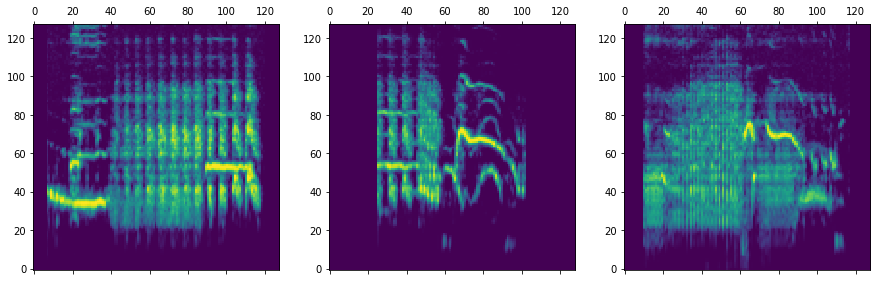

In [33]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(x1), origin='lower')
axs[1].matshow(np.squeeze(x2), origin='lower')
axs[2].matshow(np.squeeze(x3), origin='lower')

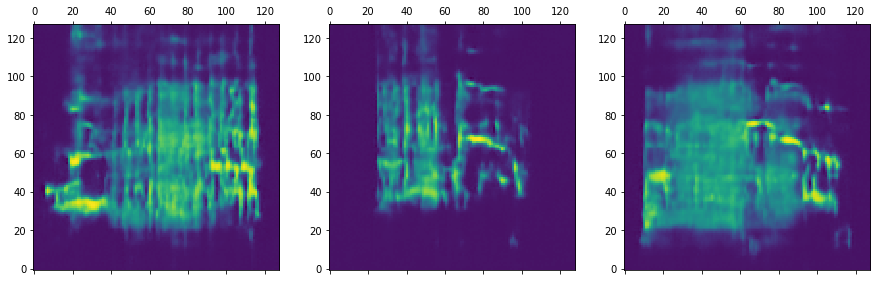

In [34]:
pt1, pt2, pt3 = model.encode(exdat)

xr1, xr2, xr3 = model.decode(np.vstack([pt1, pt2, pt3]))

fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].matshow(np.squeeze(xr1.numpy()), origin='lower')
axs[1].matshow(np.squeeze(xr2.numpy()), origin='lower')
axs[2].matshow(np.squeeze(xr3.numpy()), origin='lower')

In [35]:
#pt1x,pt2x,pt3x =gen_func(tf.stack([pt1,pt2,pt3]))

#get proportions
z_list = []
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        A = 1 - C - B
        z_list.append(
            C * pt1 +
            B * pt2 + 
            A * pt3
        )
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list).numpy()

# make diagram
Jdiagram = np.ones((x_list.shape[1]*(interp_len), x_list.shape[2]*(interp_len+2), x_list.shape[3]))
np.shape(Jdiagram)

#populate
i = 0
for ci, C in enumerate(np.linspace(0, 1, interp_len)):
    for bi, B in enumerate(np.linspace(0, 1, interp_len)):
        Jdiagram[(interp_len -1 - bi)*x_list.shape[1]:((interp_len - bi))*x_list.shape[1], (ci+1)*x_list.shape[2]:(ci+2)*x_list.shape[2], :] = x_list[i]
        i+=1
Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        :x_list.shape[2], :] = x3

Jdiagram[(interp_len - 1)*x_list.shape[1]: (interp_len)*x_list.shape[1], 
        (interp_len +1)*x_list.shape[2]: (interp_len+2)*x_list.shape[2] , :] = x1

Jdiagram[: x_list.shape[1], 
        :x_list.shape[2], :] = x2

(-0.5, 895.5, -0.5, 639.5)

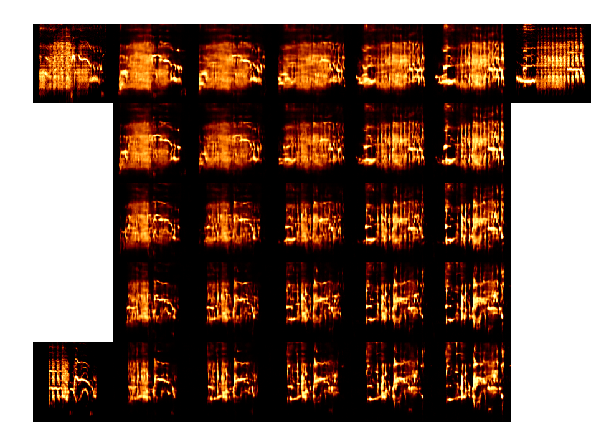

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(np.squeeze(Jdiagram), vmin = 0, cmap=plt.cm.afmhot, origin = 'lower')
ax.axis('off')
#save_fig(FIGURE_DIR / 'networks' / 'starling128'/ ('GAIA_JDiagram_128'), dpi=300, save_jpg=True)

### make reconstruction

In [38]:
z_list = []
n_frames = 50
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt2 + (1-ii) *pt1)
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt3 + (1-ii) *pt2)
for ii in np.linspace(0,1,n_frames):
    z_list.append(ii * pt1 + (1-ii) *pt3)
z_list = np.vstack(z_list)
# get X
x_list = gen_func(z_list).numpy()
np.shape(x_list)

(150, 128, 128, 1)

In [41]:
from avgn.signalprocessing.spectrogramming import (
    spectrogram, melspectrogram, inv_spectrogram, _build_mel_basis,
    _build_mel_inversion_basis, spectrogram_librosa, inv_spectrogram_librosa, _mel_to_linear)
from avgn.utils.hparams import HParams
from IPython.display import display, Audio

hparams = HParams(
    num_mels = 128,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -45,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

rate = 44100

_mel_basis = _build_mel_basis(hparams, rate, rate)
_mel_inversion_basis = _build_mel_inversion_basis(_mel_basis)

In [42]:
from PIL import Image

rescale_factor = 0.23

def resize_spec(spec, scaling_factor=10):
    resize_shape = [int(np.shape(spec)[1] / scaling_factor), np.shape(spec)[0]]
    resize_spec = np.array(Image.fromarray(spec).resize(resize_shape, Image.ANTIALIAS))
    return resize_spec

x_list_rec_vae = []
for frame in tqdm(x_list):
    melspec = resize_spec(np.squeeze(frame), scaling_factor=rescale_factor)
    mel_inv_spec = _mel_to_linear(melspec, _mel_inverse_basis = _mel_inversion_basis)
    signal_mel_inv = inv_spectrogram_librosa(mel_inv_spec, rate, hparams)
    #signal_mel_inv = nr.reduce_noise(signal_mel_inv, noise_clip=signal_mel_inv[:int(rate*.05)],n_std_thresh=2)
    rec_spec = spectrogram_librosa(signal_mel_inv, rate, hparams)
    x_list_rec_vae.append(rec_spec)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [43]:
np.shape(x_list_rec_vae)

(150, 513, 556)

In [44]:
from matplotlib import animation, rc
from IPython.display import HTML, Image

In [45]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(figsize=(5,5))

im = ax.imshow(np.squeeze(x_list_rec_vae[0]), interpolation='none', aspect='auto',origin="lower", vmin = 0, cmap=plt.cm.afmhot)
ax.axis('off')
def init():
    im.set_data(np.squeeze(x_list_rec_vae[0]))
    return [im]

def animate_func(i):
    im.set_array(np.squeeze(x_list_rec_vae[i]))
    return [im]
    
anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = n_frames*3,
                               interval = 50, # in ms
                               )

plt.close(anim._fig)
# Call function to display the animation
HTML(anim.to_html5_video())

#anim.save('../../files/animation.gif', writer='imagemagick', fps=60)